## Learning to flow

This notebook shows how to wrap learnable flows into Keras using the **subclassing** `tf.keras.models.Model` to train then. It works with TF2.0 but I am not sure if this is the way to do it.

In [13]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-rc0
        !pip install tensorflow-probability==0.8.0-rc0
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-rc0  running in colab?:  False


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)

TFP Version 0.8.0-rc0
TF  Version 2.0.0-rc0


### Learning Flows with TF 2.0

Let's create a flow using parameters, which can be learned. We use masked Autoregressive flows for that. 

dtype('float32')

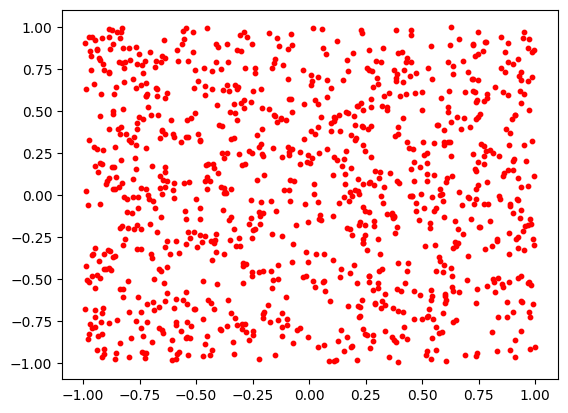

In [15]:
def sample(num):
    return np.array(np.random.uniform(-1,1,(num,2)), dtype='float32') #A real hard problem

X = sample(1000)
xlim, ylim = [-2, 2], [-2, 2]
plt.scatter(X[:, 0], X[:, 1], s=10, color='red')
X.dtype

### Makeing a Keras model

#### Subclassing a Keras model
We build our own model. As suggested in: https://www.tensorflow.org/beta/tutorials/quickstart/advanced we wrap the model into a Keras model class, by subclassing `tf.keras.models.Model`.

In [16]:
# See also https://github.com/tensorflow/probability/blob/master/tensorflow_probability/python/bijectors/real_nvp.py
from pylab import *
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

class MAF(tf.keras.models.Model):

    def __init__(self, *, output_dim, num_masked, **kwargs): #** additional arguments for the super class
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.num_masked = num_masked
        self.shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(hidden_layers=[128, 128])
        # Defining the bijector
        num_bijectors = 5
        bijectors=[]
        for i in range(num_bijectors):
            bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=self.shift_and_log_scale_fn))
            bijectors.append(tfb.Permute(permutation=[1, 0]))
        # Discard the last Permute layer.
        bijector = tfb.Chain(list(reversed(bijectors[:-1])))
        
        # Defining the flow
        self.flow = tfd.TransformedDistribution(
            distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
            bijector=bijector)

    def call(self, *inputs): 
        return self.flow.bijector.forward(*inputs)
    
    def getFlow(self, num):
        return self.flow.sample(num)

print(X.shape)
model = MAF(output_dim=2, num_masked=1)
#model.summary() #Yields an error. The model needs called before it is build.
_ = model(X) 
model.summary()

(1000, 2)
Model: "maf_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 17,412
Trainable params: 17,412
Non-trainable params: 0
_________________________________________________________________


In [17]:
# model.load_weights('test_w.h5') #Loading a saved version of the weights 

In [18]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
# with tf.GradientTape() as tape:
#         #predictions = model(X)
#     loss = -tf.reduce_mean(model.flow.log_prob(X)) 
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [19]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

@tf.function #Adding the tf.function makes it about 10 times faster!!!
def train_step(X): 
    with tf.GradientTape() as tape:
        loss = -tf.reduce_mean(model.flow.log_prob(X)) 
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss      

In [20]:
from time import time
start = time()
for i in range(501):
    #Xs = sample(1000) #Creat new training data
    loss = train_step(X)
    if (i % 50 == 0):
        print(i, " ",loss.numpy(), (time()-start))
        start = time()

0   2.089791 1.588029146194458
50   1.7651639 0.7275280952453613
100   1.7606984 0.7305605411529541
150   1.7579772 0.729339599609375
200   1.7546887 0.7471411228179932
250   1.739023 0.7440760135650635
300   1.6222875 0.7428576946258545
350   1.5743008 0.7356913089752197
400   1.5645852 0.7431762218475342
450   1.5522237 0.7524819374084473
500   1.5463607 0.7396209239959717


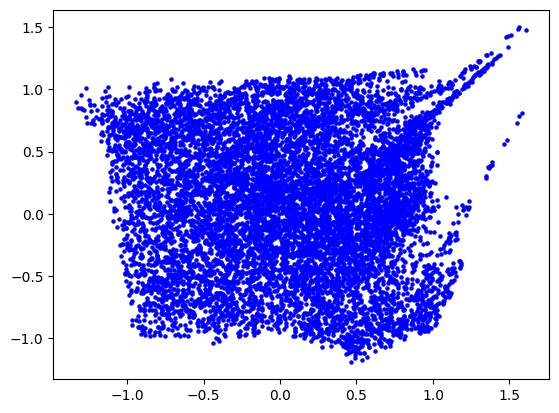

In [21]:
XF = model.flow.sample(10000) 
plt.scatter(XF[:, 0], XF[:, 1], s=5, color='blue')

In [22]:
model.save_weights('test_w.h5') #You can't save the model, but the weights

### Functional API 
Did not get this API to work.

In [23]:
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
from tensorflow.keras.models import Model
from tensorflow.keras import Input

# This returns a tensor
inputs = Input(shape=(784,))
output_dim=2
num_masked=1

shift_and_log_scale_fn = tfb.masked_autoregressive_default_template(hidden_layers=[128, 128])
# Defining the bijector
num_bijectors = 5
bijectors=[]
for i in range(num_bijectors):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=shift_and_log_scale_fn))
    bijectors.append(tfb.Permute(permutation=[1, 0]))
# Discard the last Permute layer.
bijector = tfb.Chain(list(reversed(bijectors[:-1])))

# Defining the flow
flow = tfd.TransformedDistribution(
    distribution=tfd.MultivariateNormalDiag(loc=[0., 0.]),
    bijector=bijector)

flow.bijector.forward(X[0:10])

#model = Model(inputs=inputs, outputs=flow)

<tf.Tensor: id=10548, shape=(10, 2), dtype=float32, numpy=
array([[-0.12298701,  0.8574246 ],
       [ 0.4824433 ,  0.2706335 ],
       [-0.63409233, -0.6074494 ],
       [-0.74853235,  0.58226365],
       [ 0.24693917,  0.44413772],
       [-0.7811877 ,  0.74253637],
       [ 0.60667586, -0.40784547],
       [-0.5908862 , -0.56532097],
       [-0.38469437,  0.034169  ],
       [-0.13551612, -0.4083592 ]], dtype=float32)>

In [24]:
inputs = Input(shape=(784,))
#model = Model(inputs=inputs, outputs=flow) is not possible